# **Preprocessing and Data Exploration**
In this session, It will explore the temporal series and dimsplay some metrics, such as:
- distrbution
- sazonality
- trend
- auto-correlation

## Prepare Environment

### Imports

In [1]:
# If first execution, install libs
# !pip install --require-hashes -r requirements.txt

In [2]:
# Data analysis and data wrangling
import pandas as pd

# Plotting
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Others
import warnings
import pprint

# custom functions
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path

from utils import (
    path_to_work,
    plot_box_plot,
    save_image,
    save_dataframe,
    test_stationary,
)

### Prepare Principal Directory

In [4]:
path_to_work('notebooks')

'Changed directory to: /Users/bruno.campos/projects/forecast-of-time-series-with-stock-data/notebooks'

### Set Config

In [5]:
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

In [6]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='darkgrid', palette='deep')

## **Data Understanding**
### Collect Initial Data
The dataset to be explored was obtained through the script `src/download_trade_mini-indice.mq5`

### File Descriptions
`vale3_2021-2020.csv` - dataset

### Load Data

In [7]:
%%time

df_vale3 = pd.read_csv('data/raw/vale3_2010-2020.csv', encoding='utf8', delimiter=',', verbose=True)
df_vale3.head()

Tokenization took: 0.92 ms
Type conversion took: 2.57 ms
Parser memory cleanup took: 0.01 ms
CPU times: user 8.59 ms, sys: 5.8 ms, total: 14.4 ms
Wall time: 12.3 ms


,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 19, 2020",55.17,56.33,56.60,54.71,37.86M,-1.78%
1,"Jun 18, 2020",56.17,56.30,56.54,55.61,25.69M,-0.05%
2,"Jun 17, 2020",56.20,55.49,56.44,55.15,27.57M,1.46%
3,"Jun 16, 2020",55.39,55.49,55.50,54.22,29.17M,2.80%
4,"Jun 15, 2020",53.88,52.50,54.43,52.13,27.32M,0.90%


### Describe Data

In [8]:
df_vale3.info()
print("\nDataframe:\n{} rows\n{} columns".format(df_vale3.shape[0], df_vale3.shape[1]))

list_columns = (df_vale3.columns).tolist()
print("-"*25, "List Columns", "-"*25, end='\n')
print(list_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2495 non-null   object 
 1   Price     2495 non-null   float64
 2   Open      2495 non-null   float64
 3   High      2495 non-null   float64
 4   Low       2495 non-null   float64
 5   Vol.      2495 non-null   object 
 6   Change %  2495 non-null   object 
dtypes: float64(4), object(3)
memory usage: 136.6+ KB

Dataframe:
2495 rows
7 columns
------------------------- List Columns -------------------------
['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


**NOTES**

1. Columns:

- Date (x-axis): date of the data
- Price (y-axis): closing price. What will be predicted
- Open: opening price
- High: maximum price reached
- Low: minimum price reached
- Vol.: volume of traded shares
- Change %: percentage change compared to the previous day
<br/>

2. Context:
- Stock market: `VALE3`

<br/>

### **Explore Data**

In [9]:
df_vale3.nunique()

Date        2495
Price       1845
Open        1816
High        1852
Low         1845
Vol.        1339
Change %     927
dtype: int64

In [10]:
df_vale3.mode(dropna=False, numeric_only=True)

,Price,Open,High,Low
0,27.43,51.00,38.15,17.65
1,NaN,NaN,44.33,NaN
2,NaN,NaN,52.09,NaN
3,NaN,NaN,53.12,NaN


In [11]:
df_vale3.isnull().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [12]:
df_vale3.duplicated().any()

False

---

## **Data Preparation: Cleaning**
The analysis of the time series is univariate, meaning only the price column over time will be predicted. This ensures a better comparison among statistical models, machine learning, and deep learning approaches.

#### Prepare Columns

In [13]:
df_vale3.columns =  map(str.lower, df_vale3.columns)
print(df_vale3.columns)

list_columns = df_vale3.columns
print(list_columns)

Index(['date', 'price', 'open', 'high', 'low', 'vol.', 'change %'], dtype='object')
Index(['date', 'price', 'open', 'high', 'low', 'vol.', 'change %'], dtype='object')


#### Data
- Transform the date format from (Jun 19, 2020) to (2020-06-19).
- Convert the data type of the `date` column to `datetime64`.

In [14]:
df_vale3['date'] = pd.to_datetime(df_vale3['date'])
df_vale3 = df_vale3.iloc[::-1]
df_vale3.head(10)

,date,price,open,high,low,vol.,change %
2494,2010-05-20,39.79,40.21,40.93,39.79,6.09M,-3.61%
2493,2010-05-21,42.46,40.17,42.75,39.92,3.86M,6.71%
2492,2010-05-24,42.02,42.28,43.10,42.02,2.64M,-1.04%
2491,2010-05-25,42.39,40.86,42.67,40.23,4.53M,0.88%
2490,2010-05-26,42.17,42.96,44.52,42.17,5.53M,-0.52%
2489,2010-05-27,44.82,43.73,45.03,43.59,5.07M,6.28%
2488,2010-05-28,44.42,44.82,45.39,43.97,4.42M,-0.89%
2487,2010-05-31,45.37,44.73,45.50,44.73,4.78M,2.14%
2486,2010-06-01,44.39,44.30,45.09,44.28,3.37M,-2.16%
2485,2010-06-02,45.32,44.28,45.73,44.28,2.04M,2.10%


In [15]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 2494 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2495 non-null   datetime64[ns]
 1   price     2495 non-null   float64       
 2   open      2495 non-null   float64       
 3   high      2495 non-null   float64       
 4   low       2495 non-null   float64       
 5   vol.      2495 non-null   object        
 6   change %  2495 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 136.6+ KB


### Add index

In [16]:
df_vale3_date_index = df_vale3
df_vale3_date_index.index.names = ['date']
df_vale3_date_index.index = df_vale3['date']
df_vale3_date_index.index = pd.to_datetime(df_vale3.index)

print(df_vale3_date_index.index.freq)
print(df_vale3_date_index.index)

None
DatetimeIndex(['2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25',
               '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31',
               '2010-06-01', '2010-06-02',
               ...
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)


In [17]:
df_vale3_date_index.head()

,date,price,open,high,low,vol.,change %
date,,,,,,,
2010-05-20,2010-05-20,39.79,40.21,40.93,39.79,6.09M,-3.61%
2010-05-21,2010-05-21,42.46,40.17,42.75,39.92,3.86M,6.71%
2010-05-24,2010-05-24,42.02,42.28,43.10,42.02,2.64M,-1.04%
2010-05-25,2010-05-25,42.39,40.86,42.67,40.23,4.53M,0.88%
2010-05-26,2010-05-26,42.17,42.96,44.52,42.17,5.53M,-0.52%


### **Verify Data Quality**
- Check index
- Check for irrelevant values
- Check for outliers

#### Check Index

In [18]:
df_vale3.index

DatetimeIndex(['2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25',
               '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31',
               '2010-06-01', '2010-06-02',
               ...
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)

#### Check for outliers

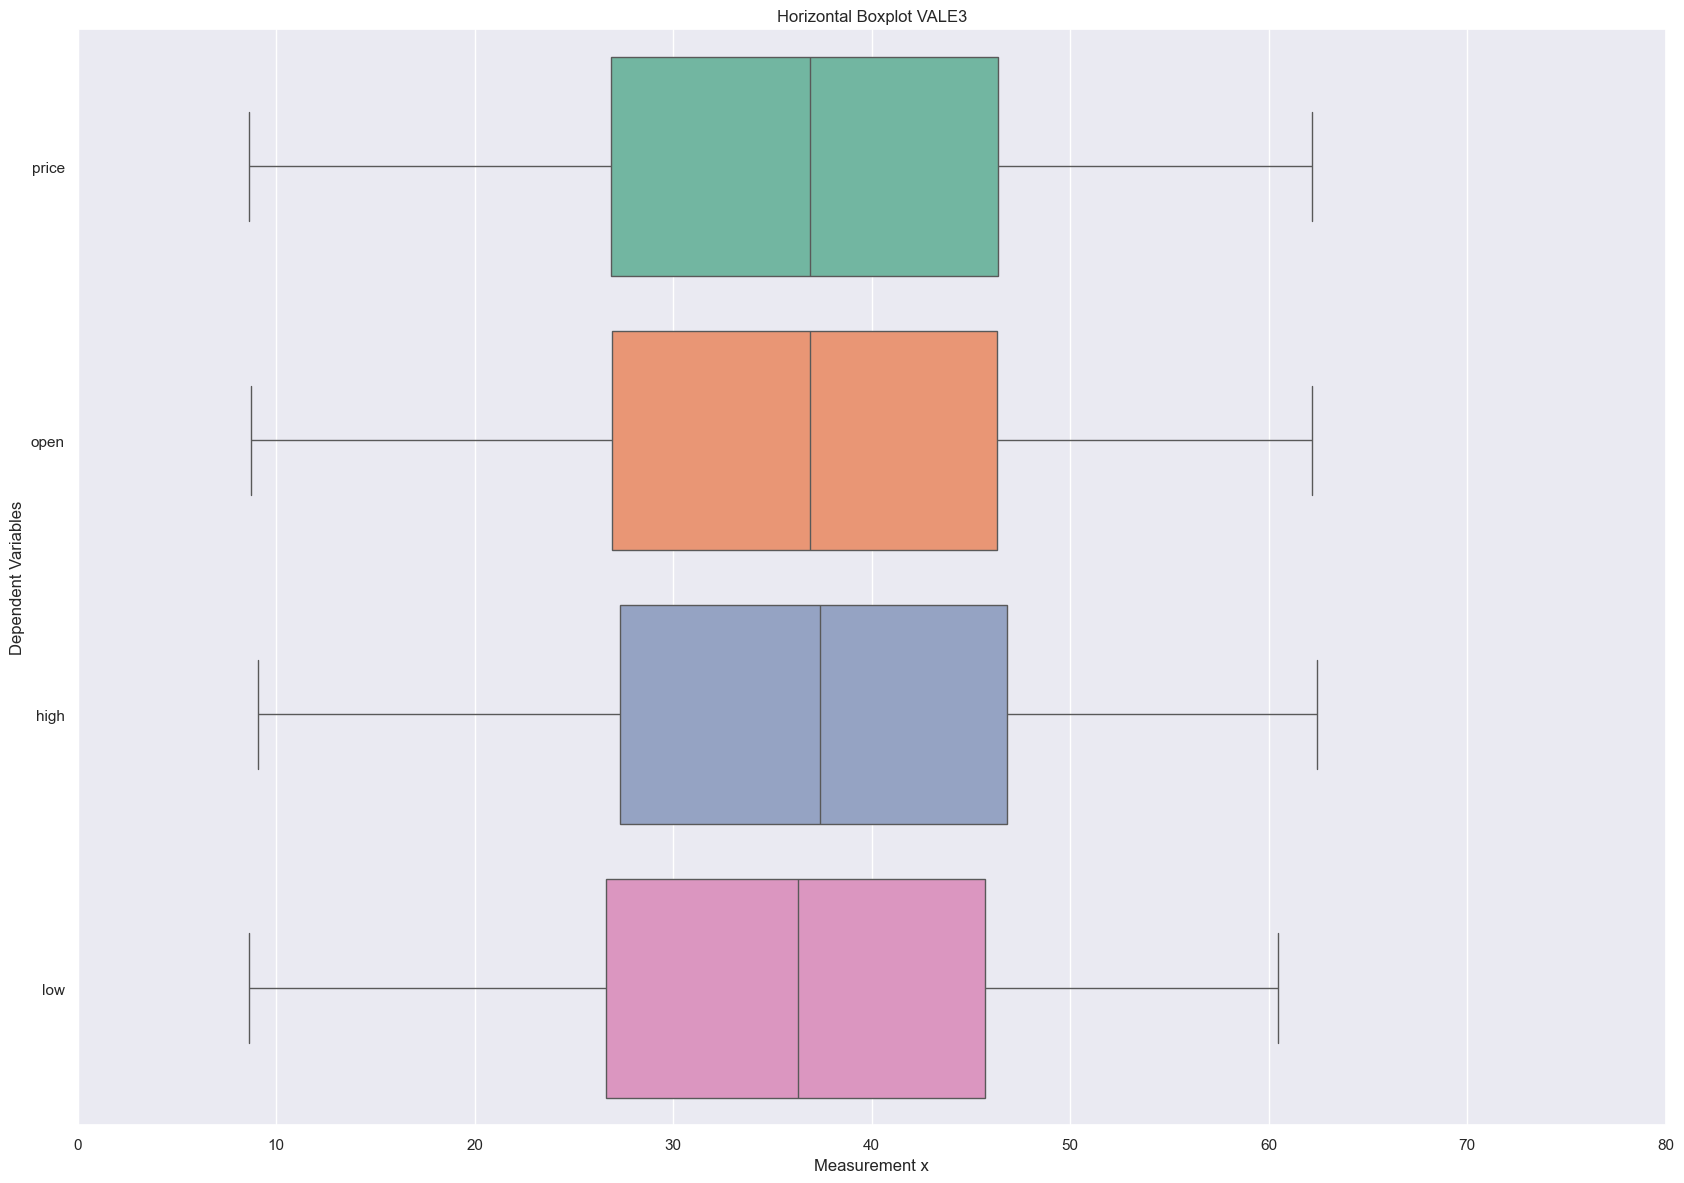

In [19]:
plot_box_plot(df_vale3, 'VALE3', (0, 80))

---

## **Data Understanding: Statistics and Plot**
### **Data Explorate**
- Analysis of Time Series Components
- Distribution
- Seasonality
- Trend
- Noise

#### distribution

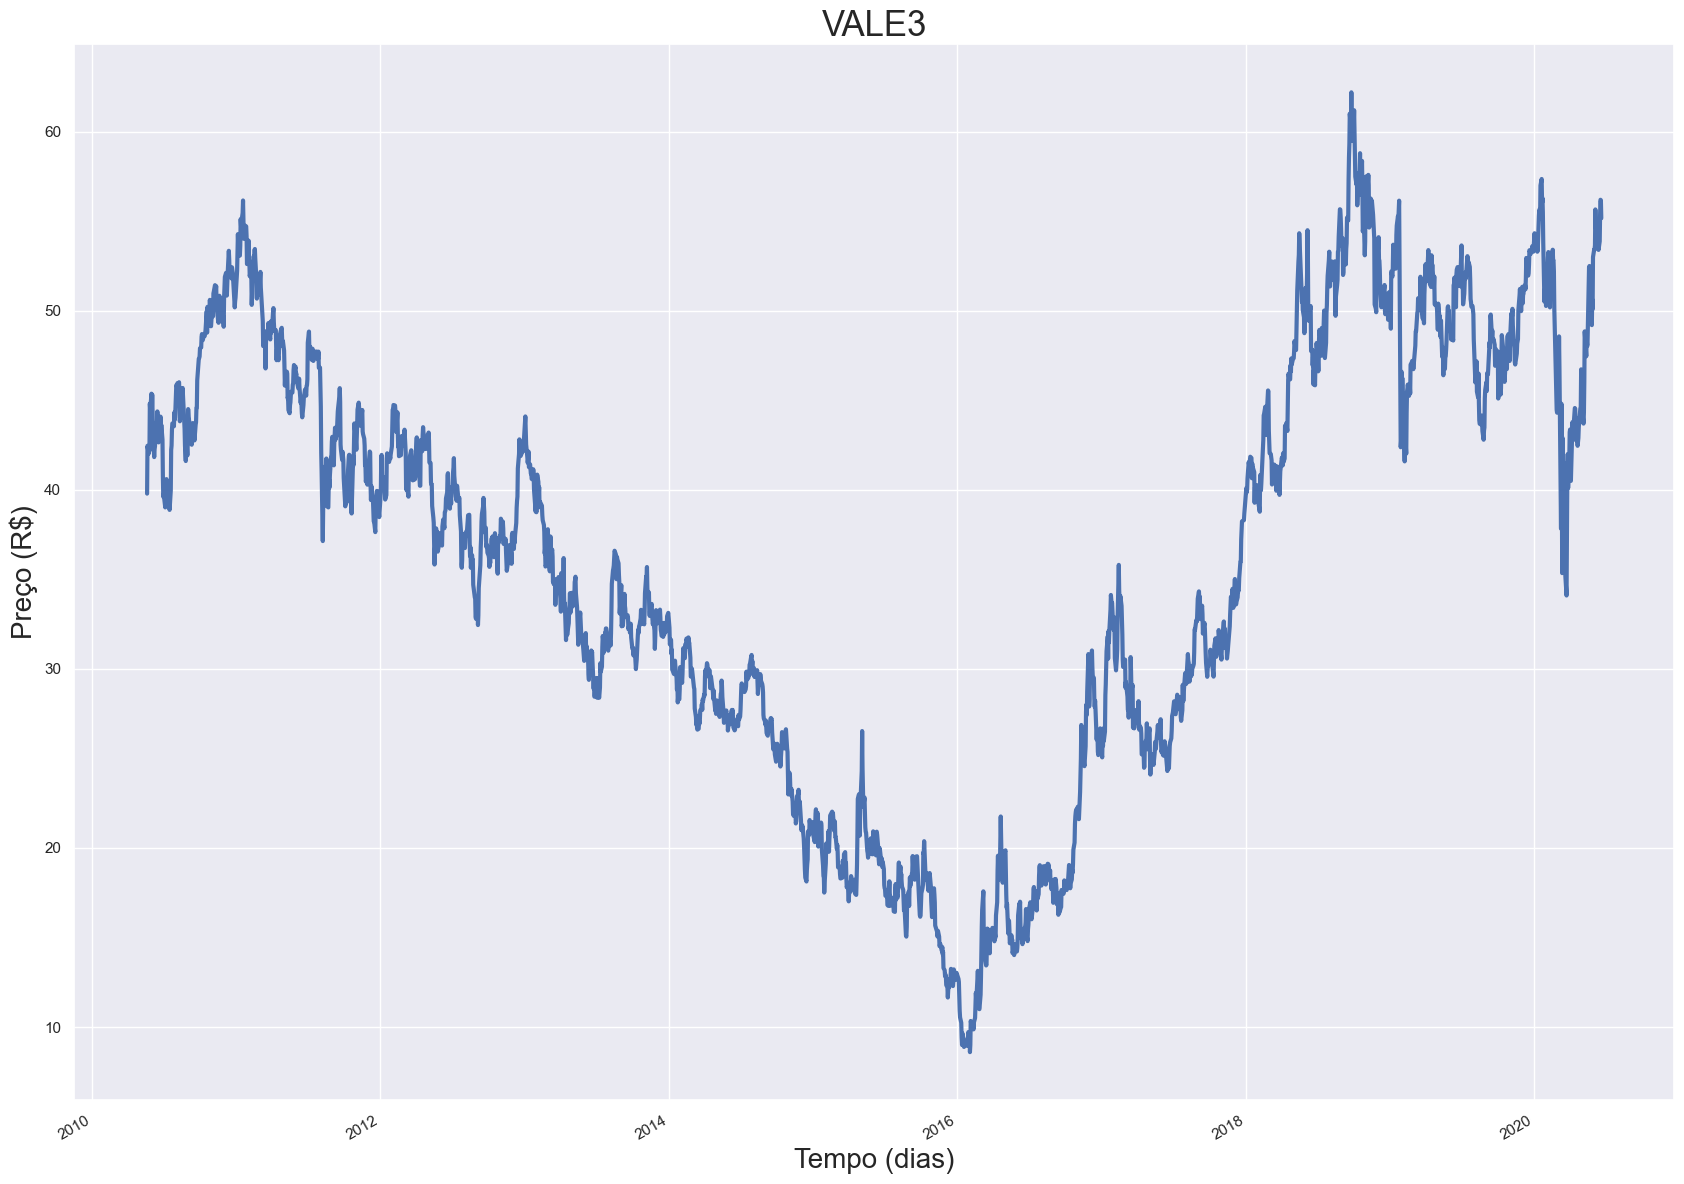

In [20]:
img_vale3_distr_line = df_vale3_date_index['price'].plot(linewidth=3)

plt.title(f'VALE3', fontsize=25)
plt.xlabel("Tempo (dias)", fontsize=20)
plt.ylabel("Preço (R$)", fontsize=20)
plt.grid(True)

In [21]:
save_image(img=img_vale3_distr_line, name='img_vale3_distr_line')

img_vale3_distr_line saved at reports/images/.


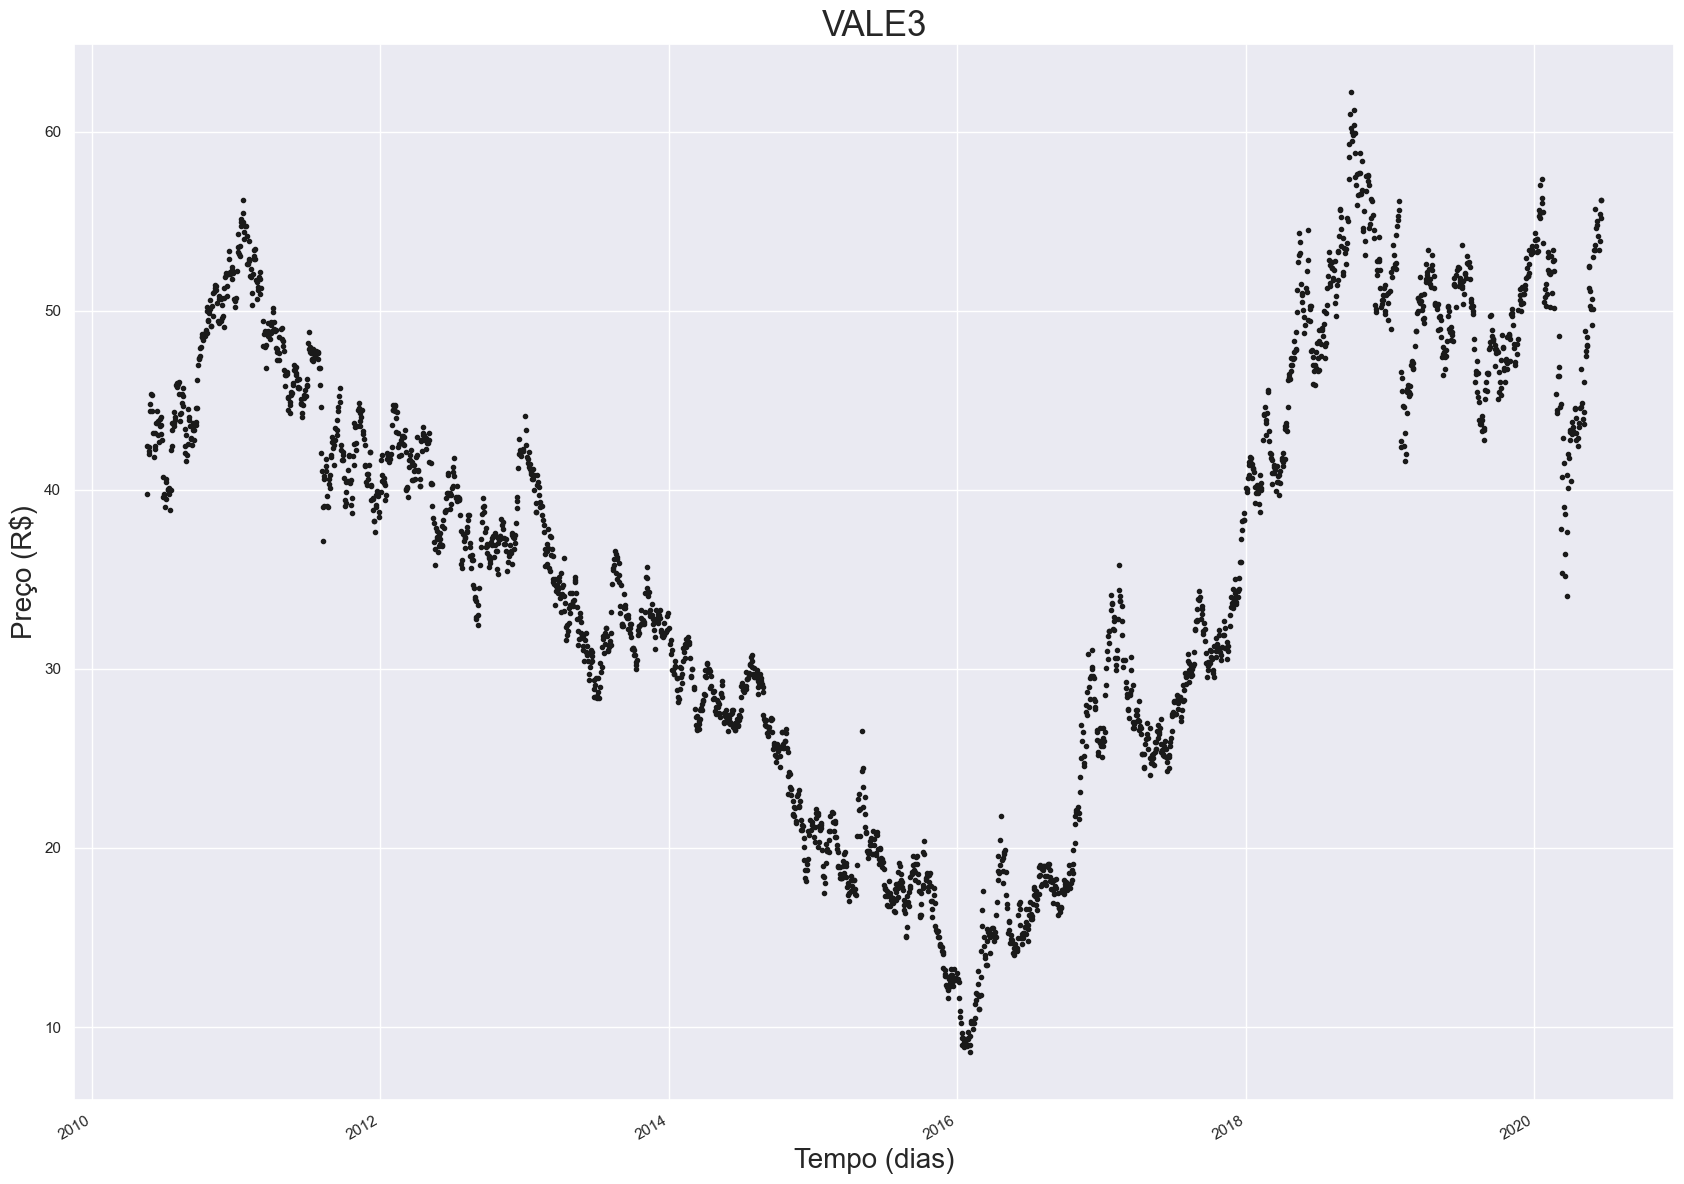

In [22]:
img_vale3_distr_scatter = df_vale3_date_index['price'].plot(style='k.')

plt.title(f'VALE3', fontsize=25)
plt.xlabel("Tempo (dias)", fontsize=20)
plt.ylabel("Preço (R$)", fontsize=20)
plt.grid(True)

In [23]:
save_image(img=img_vale3_distr_scatter, name='img_vale3_distr_scatter')

img_vale3_distr_scatter saved at reports/images/.


#### **NOTES**
- There was a significant downtrend, beginning after reaching the peak and lasting approximately 500 days.
- Following the downtrend reaching its bottom, there was a reversal, initiating an uptrend cycle.
- Currently, it appears to be in a consolidation phase.

### Time Series Decomposition
- The objective is to decompose the time series (ST).
- The time series appears to exhibit two trends, both cases showing a linear rather than exponential trend. Therefore, the decomposition will be `additive`.

In [24]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2010-05-20 to 2020-06-19
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2495 non-null   datetime64[ns]
 1   price     2495 non-null   float64       
 2   open      2495 non-null   float64       
 3   high      2495 non-null   float64       
 4   low       2495 non-null   float64       
 5   vol.      2495 non-null   object        
 6   change %  2495 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 155.9+ KB


In [25]:
decomposition_add = seasonal_decompose(df_vale3['price'], period=30, model='multiplicative')

trend = decomposition_add.trend
seasonal = decomposition_add.seasonal
residual = decomposition_add.resid

<Axes: xlabel='date', ylabel='Resíduo'>

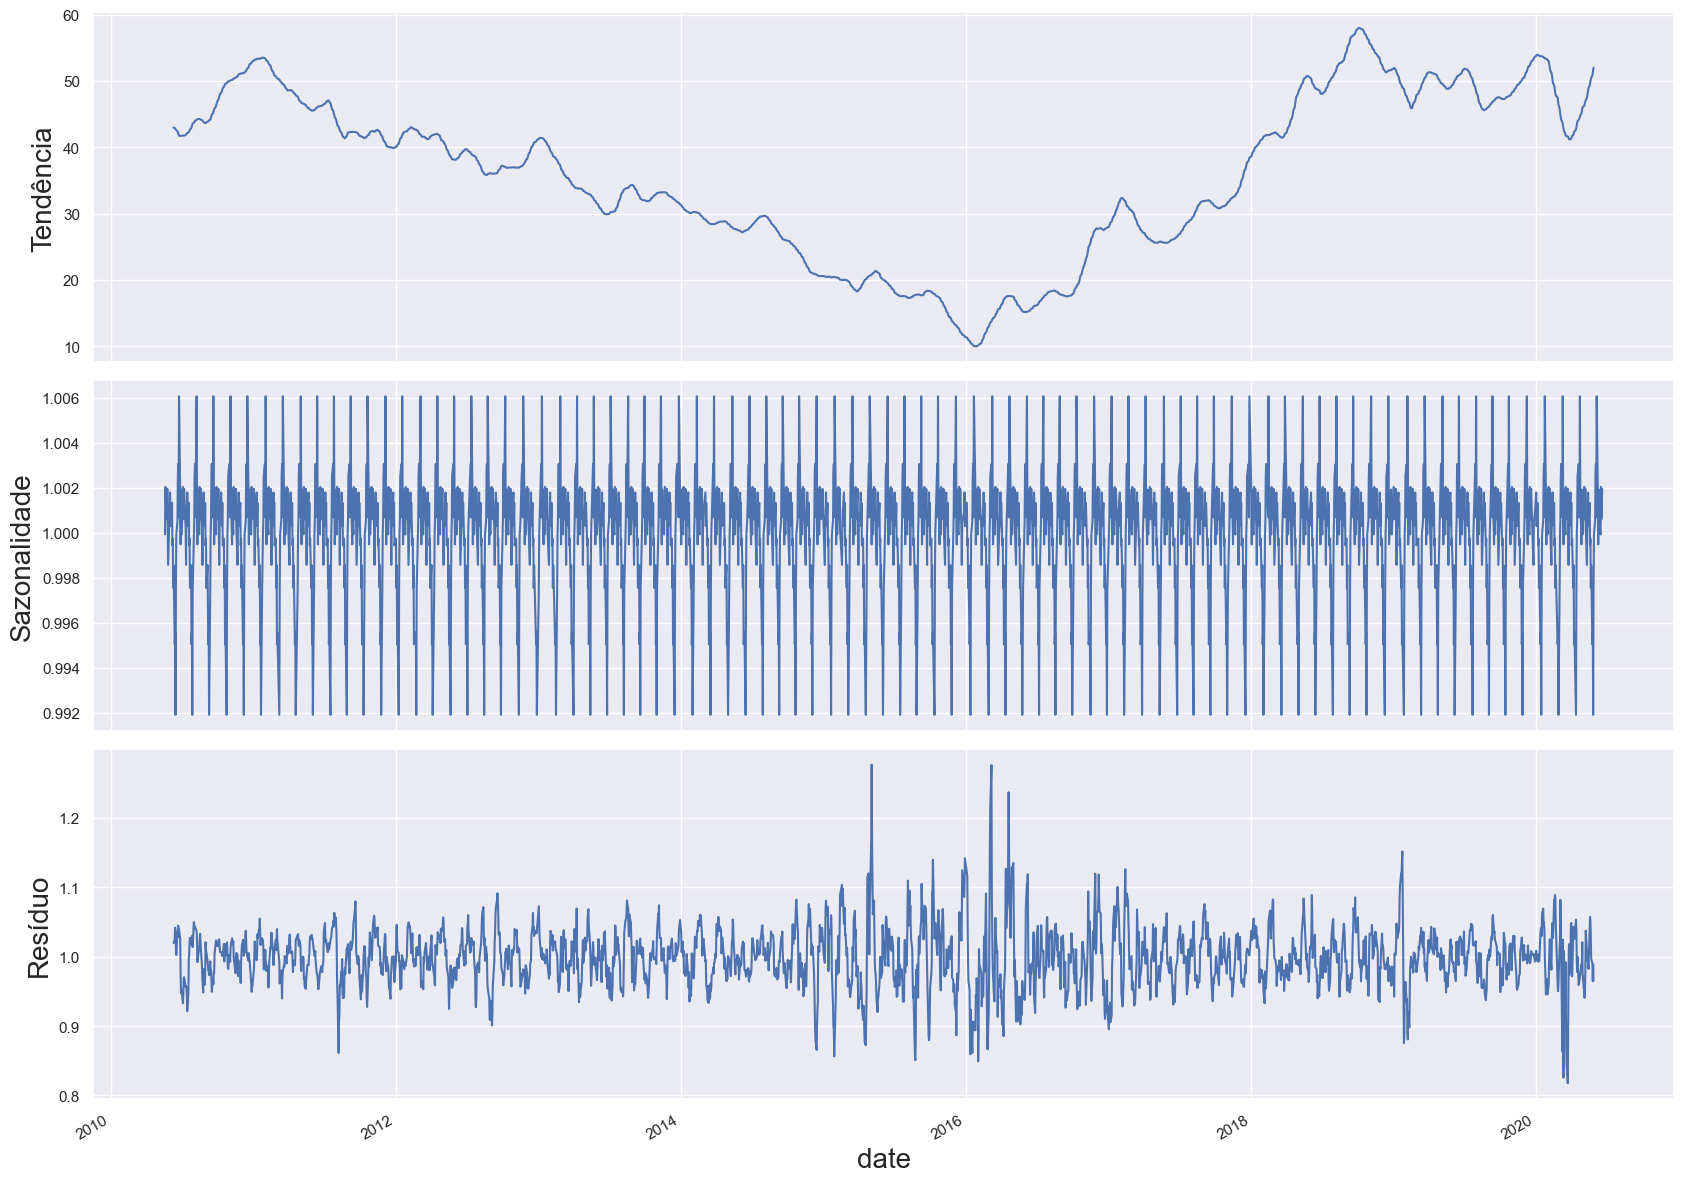

In [26]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)

axes[0].set_ylabel('Tendência', fontsize=20)
axes[1].set_ylabel('Sazonalidade', fontsize=20)
axes[2].set_ylabel('Resíduo', fontsize=20)
axes[2].set_xlabel('Tempo dias', fontsize=20)

decomposition_add.trend.plot(ax=axes[0])
decomposition_add.seasonal.plot(ax=axes[1])
decomposition_add.resid.plot(ax=axes[2])

img_df_vale3_without_trend saved at reports/images/.


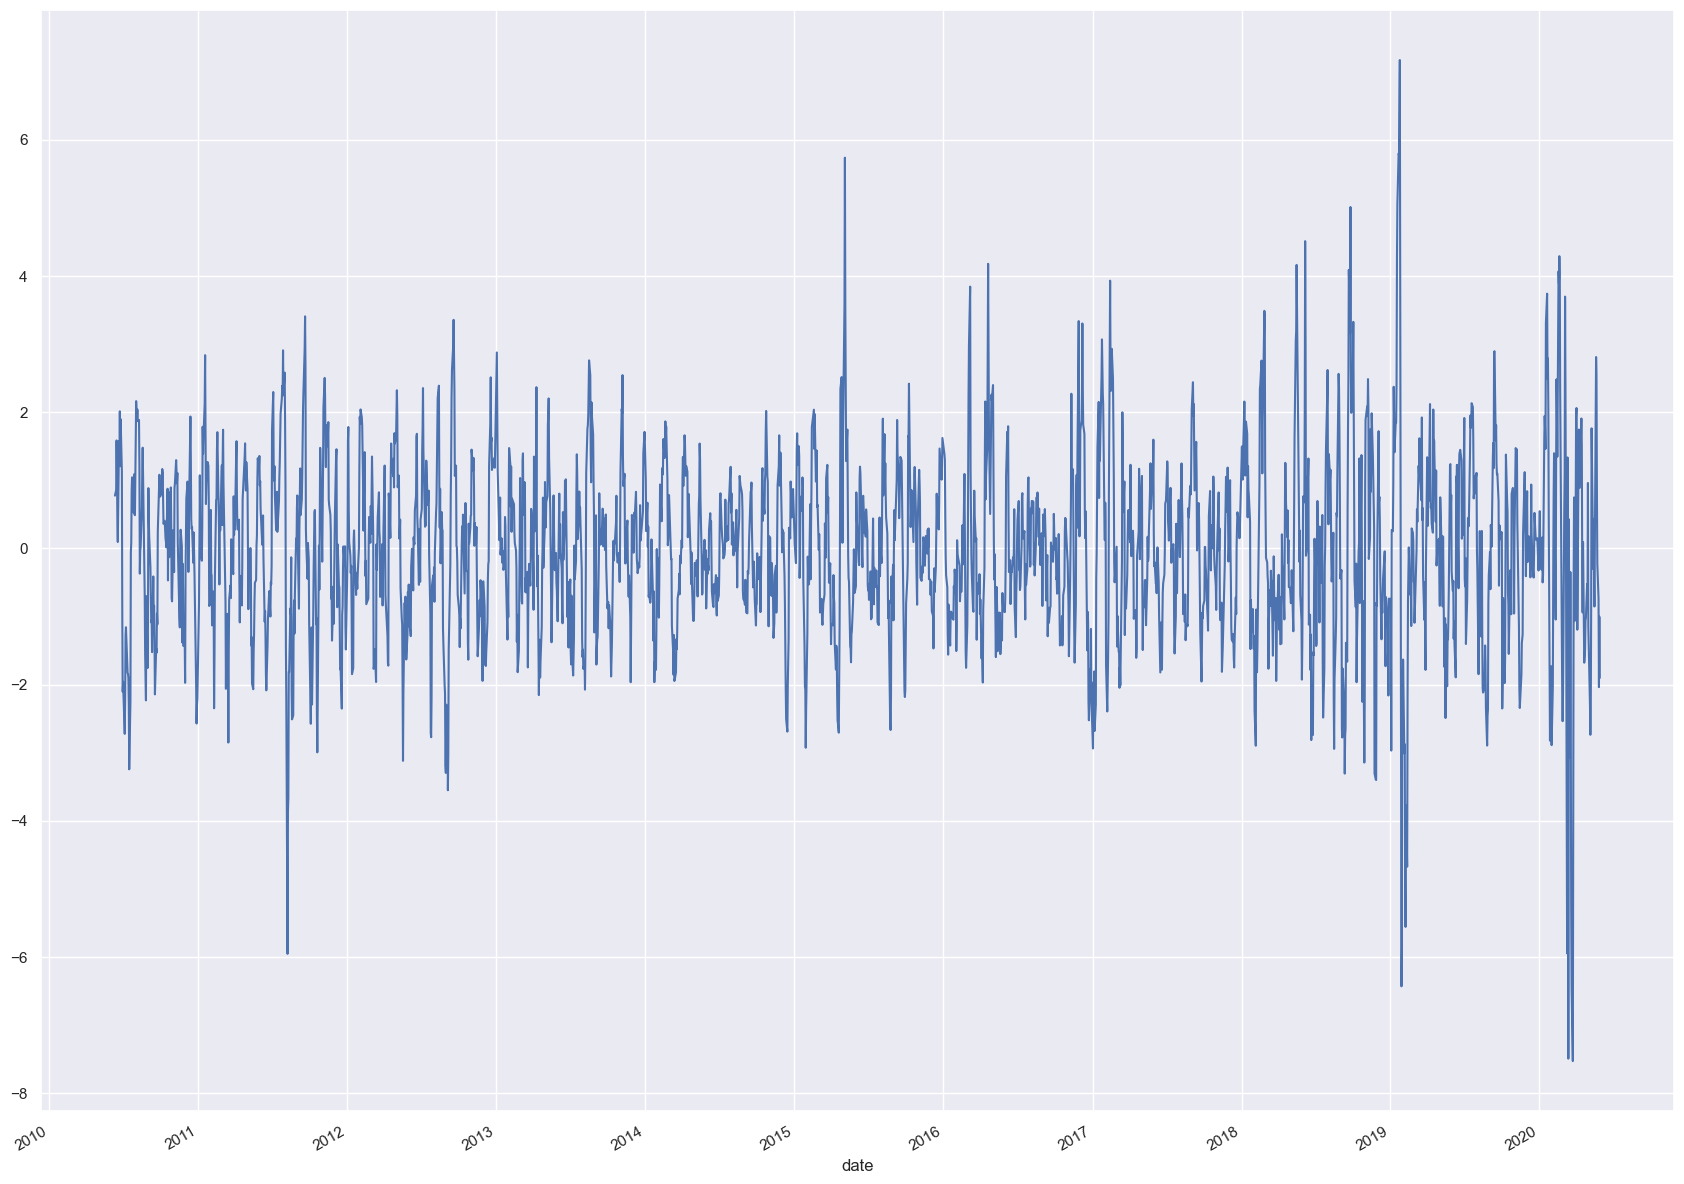

In [27]:
df_vale3_without_trend = df_vale3['price'] - trend
img_df_vale3_without_trend = df_vale3_without_trend.plot()
save_image(img=img_df_vale3_without_trend, name='img_df_vale3_without_trend')

img_df_vale3_without_seasonal saved at reports/images/.


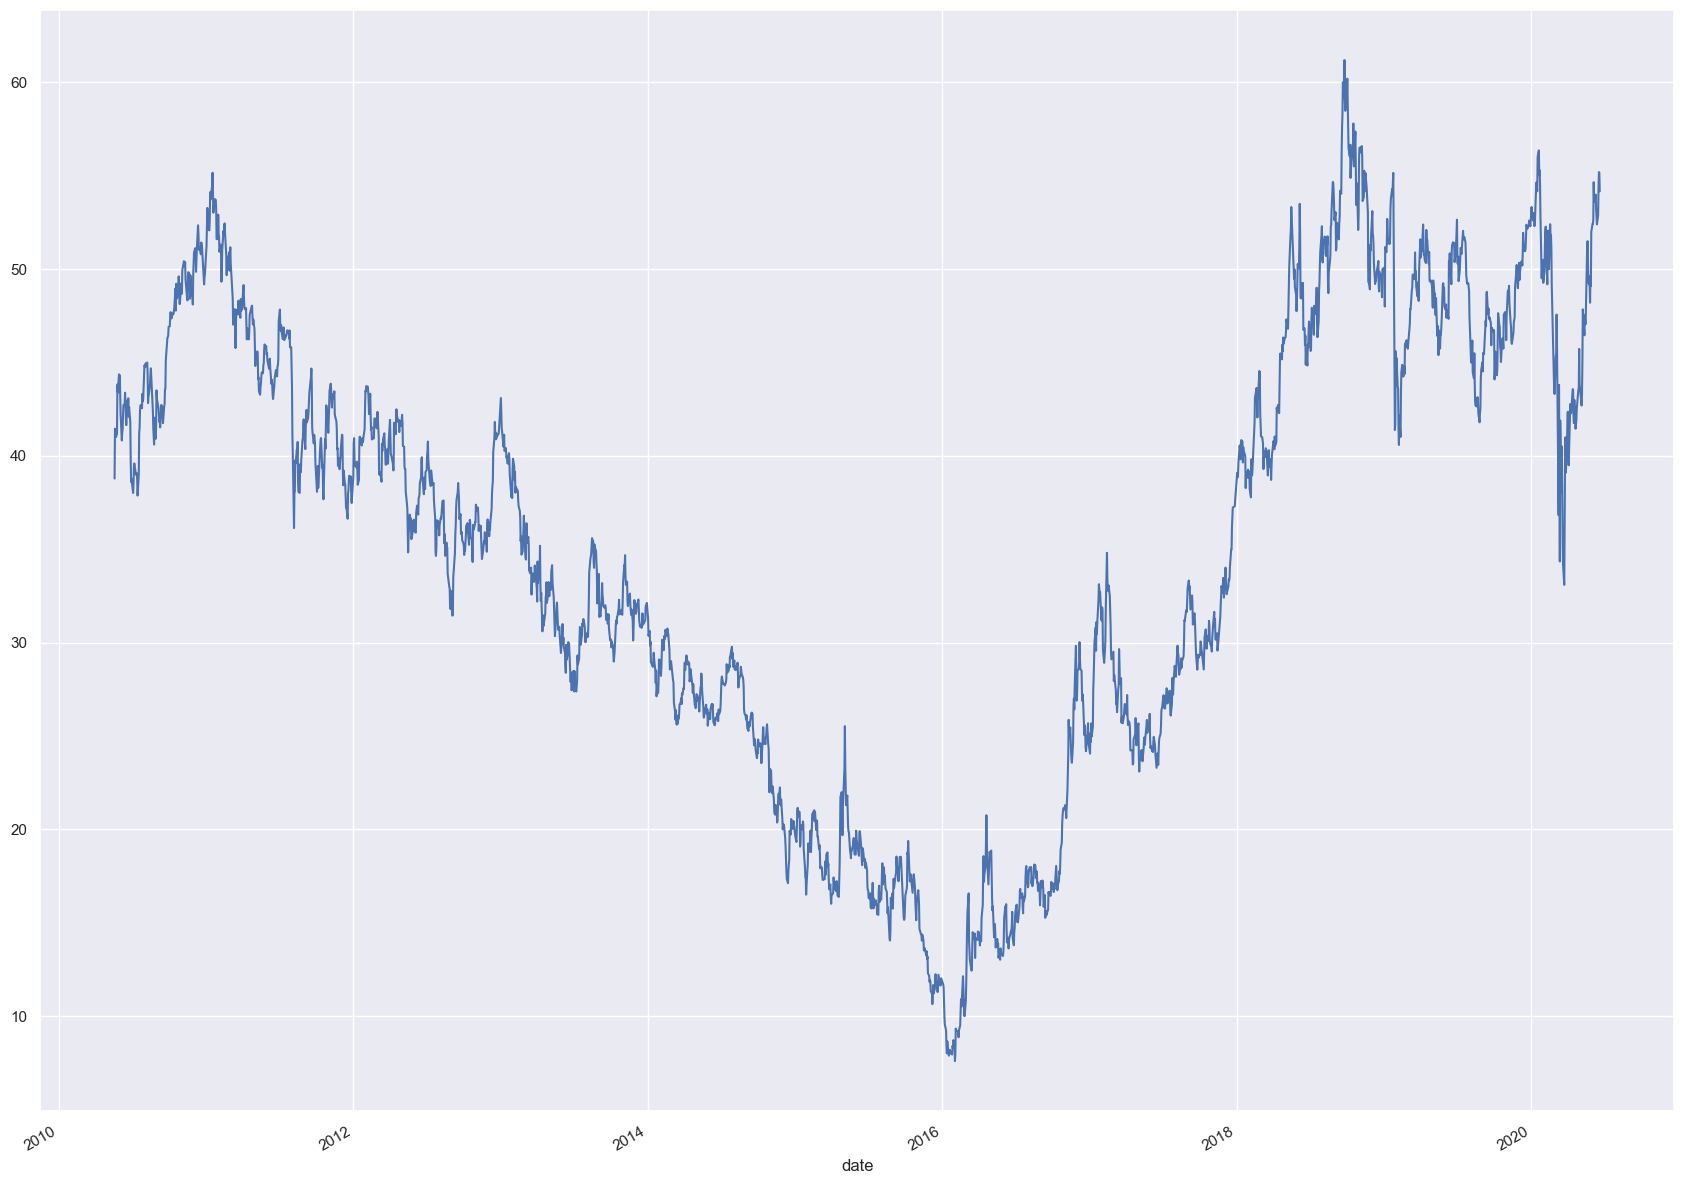

In [28]:
df_vale3_without_seasonal = df_vale3['price'] - seasonal
img_df_vale3_without_seasonal = df_vale3_without_seasonal.plot()
save_image(img=img_df_vale3_without_seasonal, name='img_df_vale3_without_seasonal')

df_vale3_without_resid saved at reports/images/.


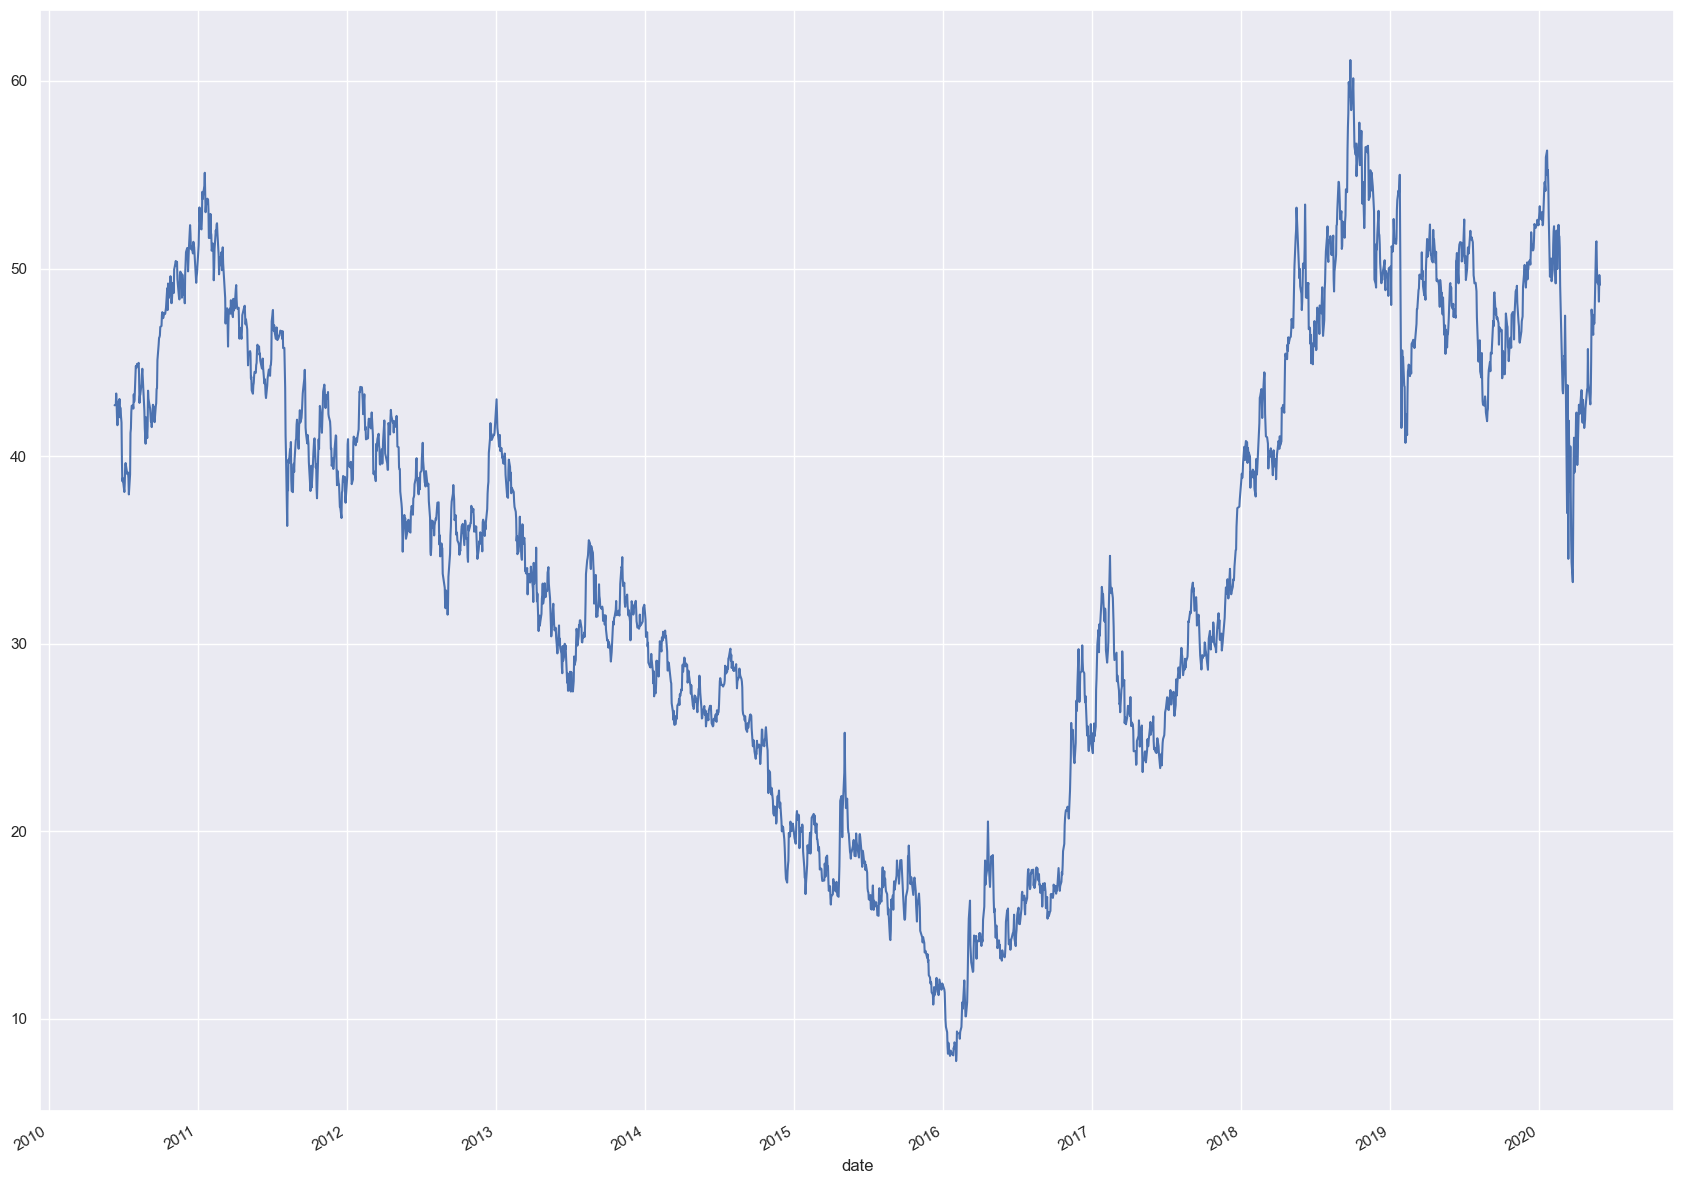

In [29]:
df_vale3_without_resid = df_vale3['price'] - residual
df_vale3_without_resid = df_vale3_without_resid.plot()
save_image(img=df_vale3_without_resid, name='df_vale3_without_resid')

NOTES:

The time series decomposition reveals:
- There have been 2 major trends, and in recent years, the price does not exhibit a clear trend.
- Seasonality occurs every 30 days.
- It is notable that from 2018 onwards, the residuals have increased. During this same period, the time series did not exhibit a clear trend.

### **Auto-correlation**
Autoregressive models like ARIMA assume that previous observations are useful for predicting the value of the next time step.
The stronger the correlation between the output variable and a specific lagged variable, the more weight the autoregressive model can place on that variable.

NOTES:
- Correlation is calculated between the variable and itself at previous time steps, hence the name autocorrelation.
- Calculating correlation can also help in selecting which lagged variables will be useful in a model and which will not.
- If lagged variables show low or no correlation with the output variable, the time series may not be predictable.
- Used Pearson correlation.

#### wiki
Autocorrelation analysis is a mathematical tool used to identify repetitive patterns, such as the presence of a periodic signal obscured by noise or the identification of the fundamental frequency absent in a signal implied by its harmonic frequencies. It is commonly employed in signal processing to analyze functions or series of values, such as signals in the time domain.

In [30]:
df_vale3_date_index['price'].autocorr(lag=1)

0.9972513584845024

img_df_vale3_autocorr_1 saved at reports/images/.


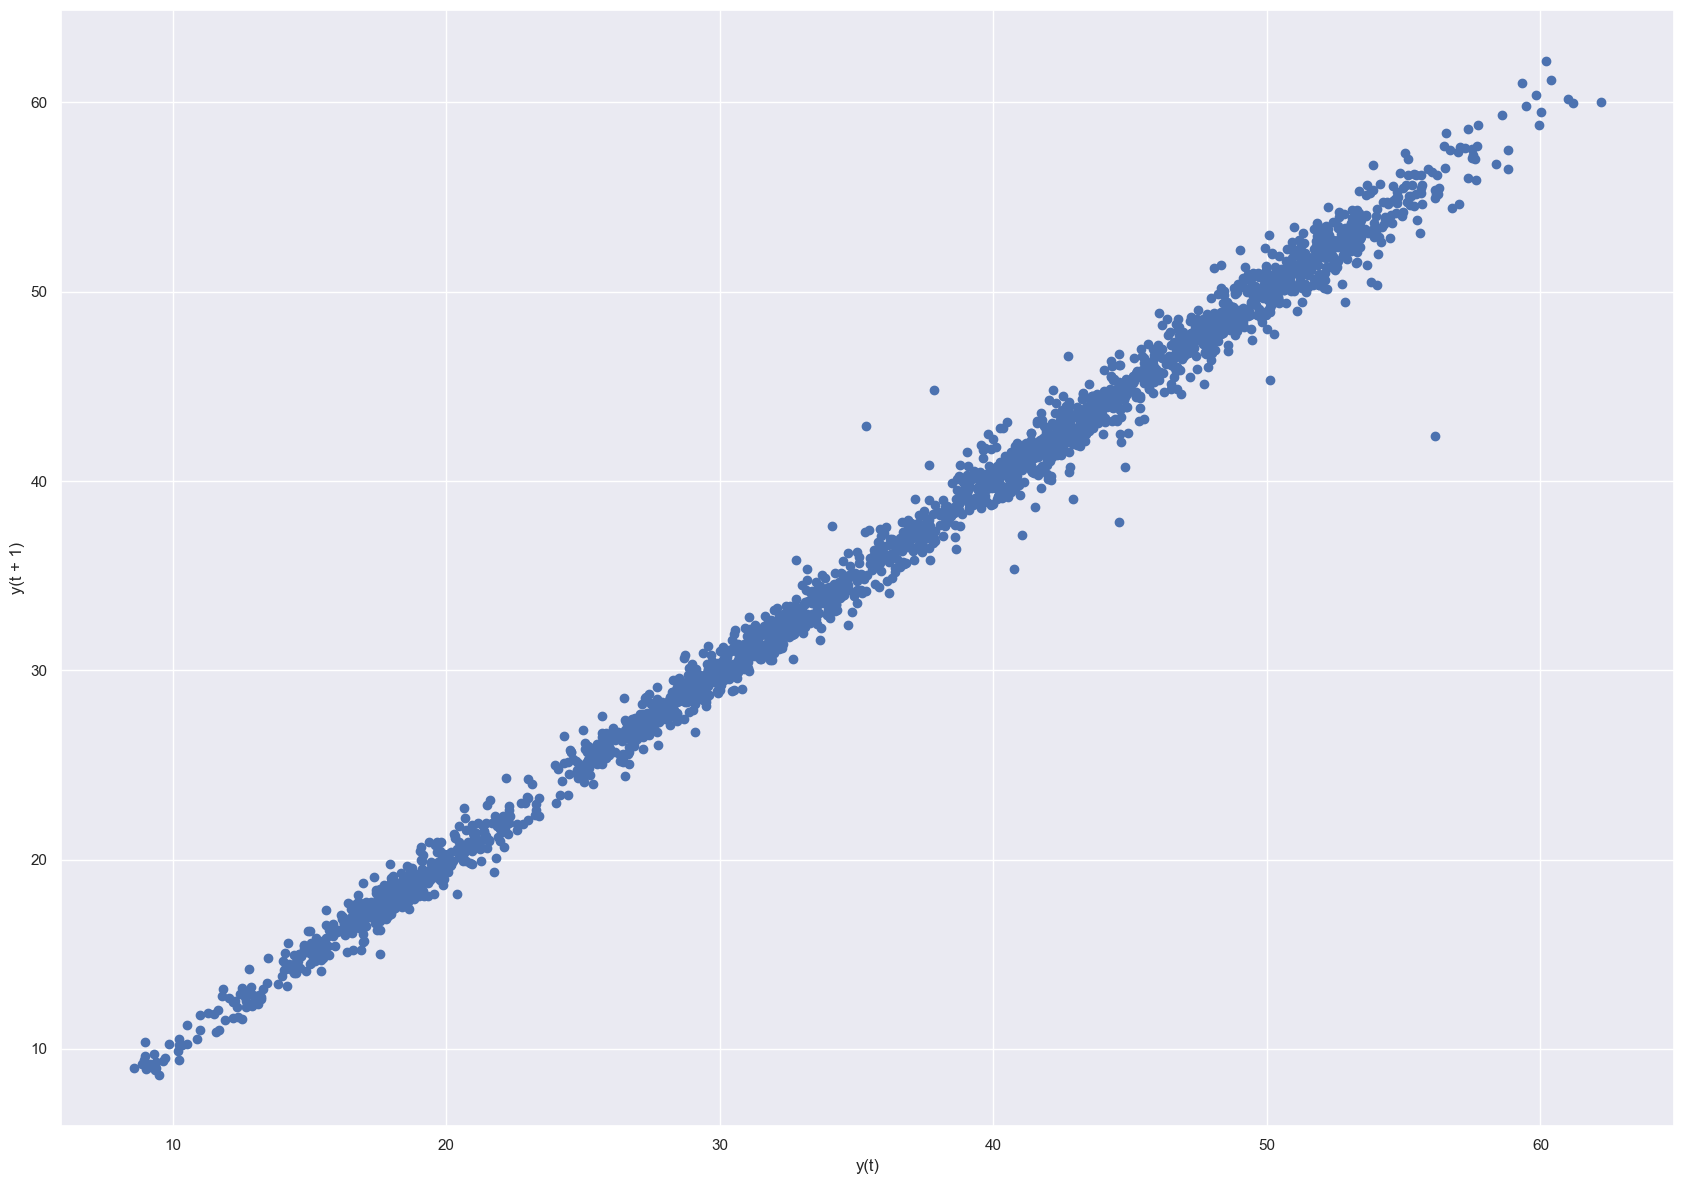

In [31]:
img_df_vale3_autocorr_1 = lag_plot(df_vale3_date_index['price'], lag=1)
save_image(img=img_df_vale3_autocorr_1, name='img_df_vale3_autocorr_1')

In [32]:
df_vale3_date_index['price'].autocorr(lag=30)

0.9459357661702158

img_df_vale3_autocorr saved at reports/images/.


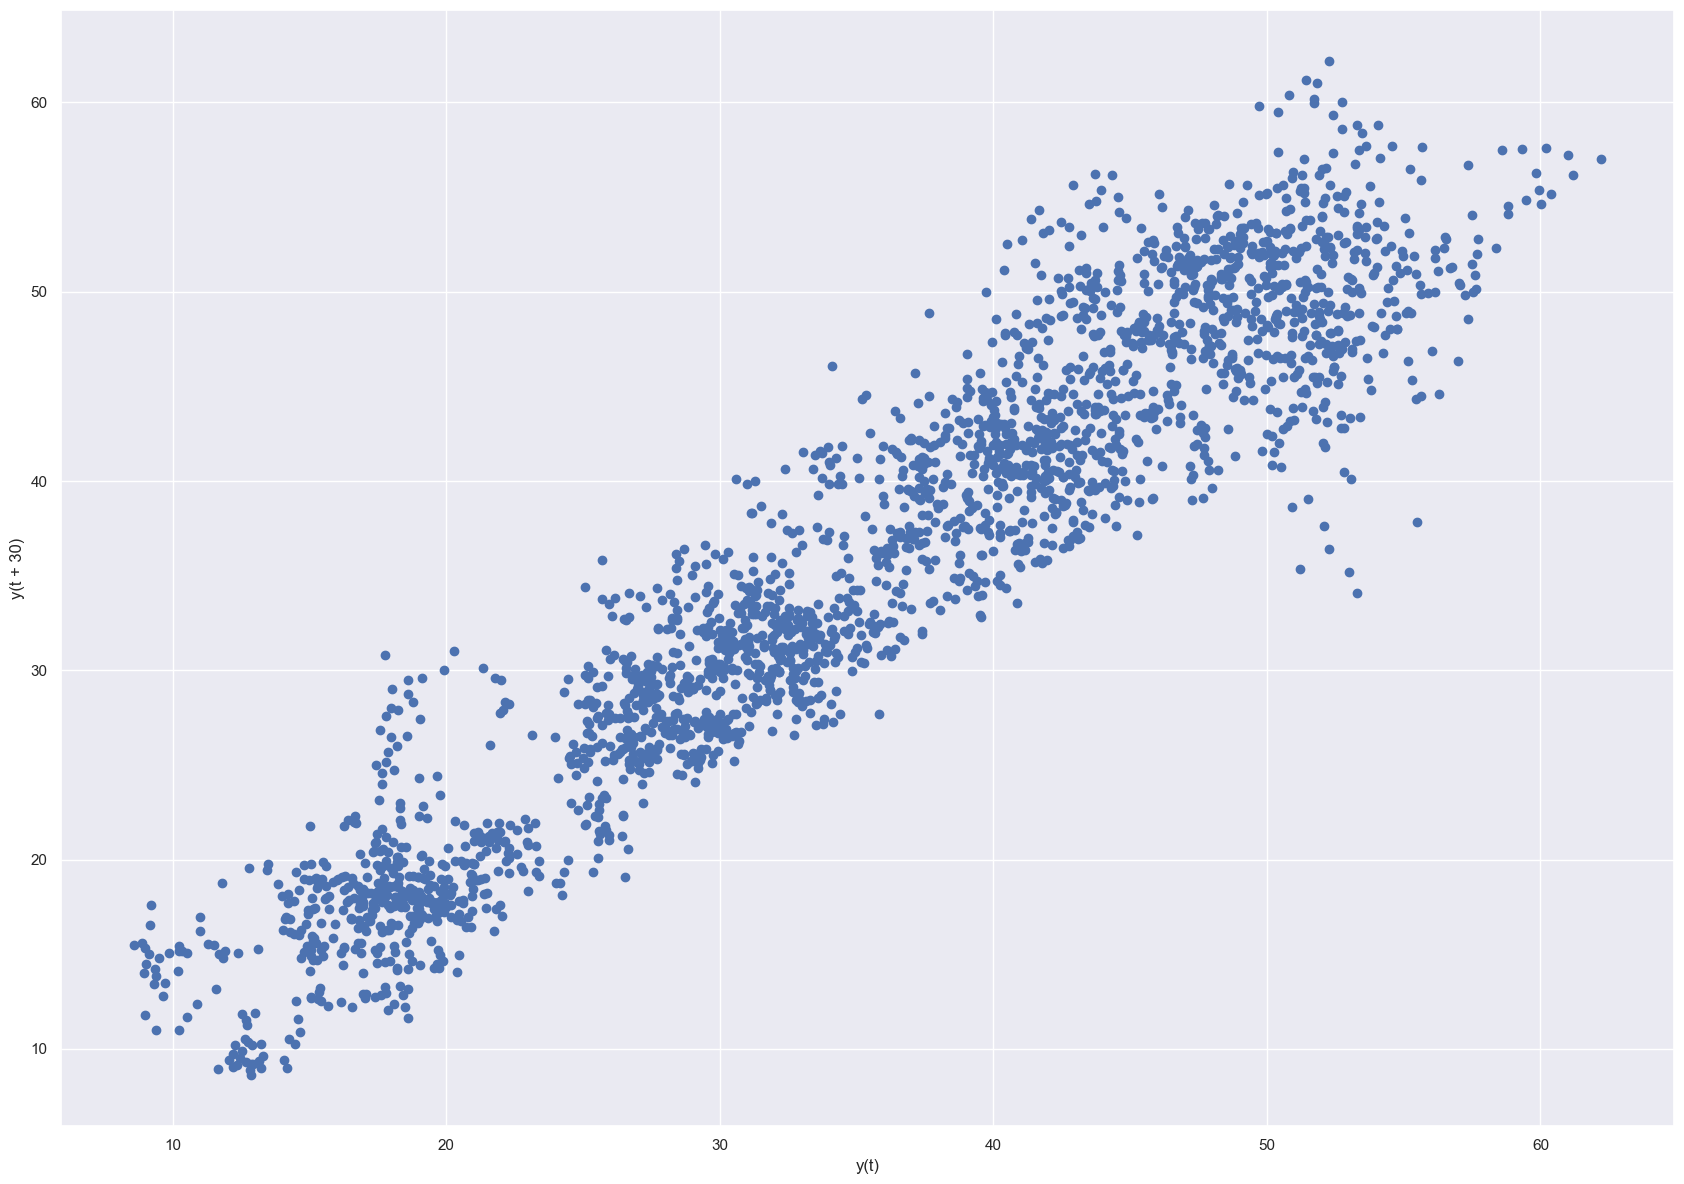

In [33]:
img_df_vale3_autocorr = lag_plot(df_vale3_date_index['price'], lag=30)
save_image(img=img_df_vale3_autocorr, name='img_df_vale3_autocorr')

In [34]:
df_vale3_date_index['price'].autocorr(lag=313)

0.5017662028027128

img_df_vale3_autocorr_313 saved at reports/images/.


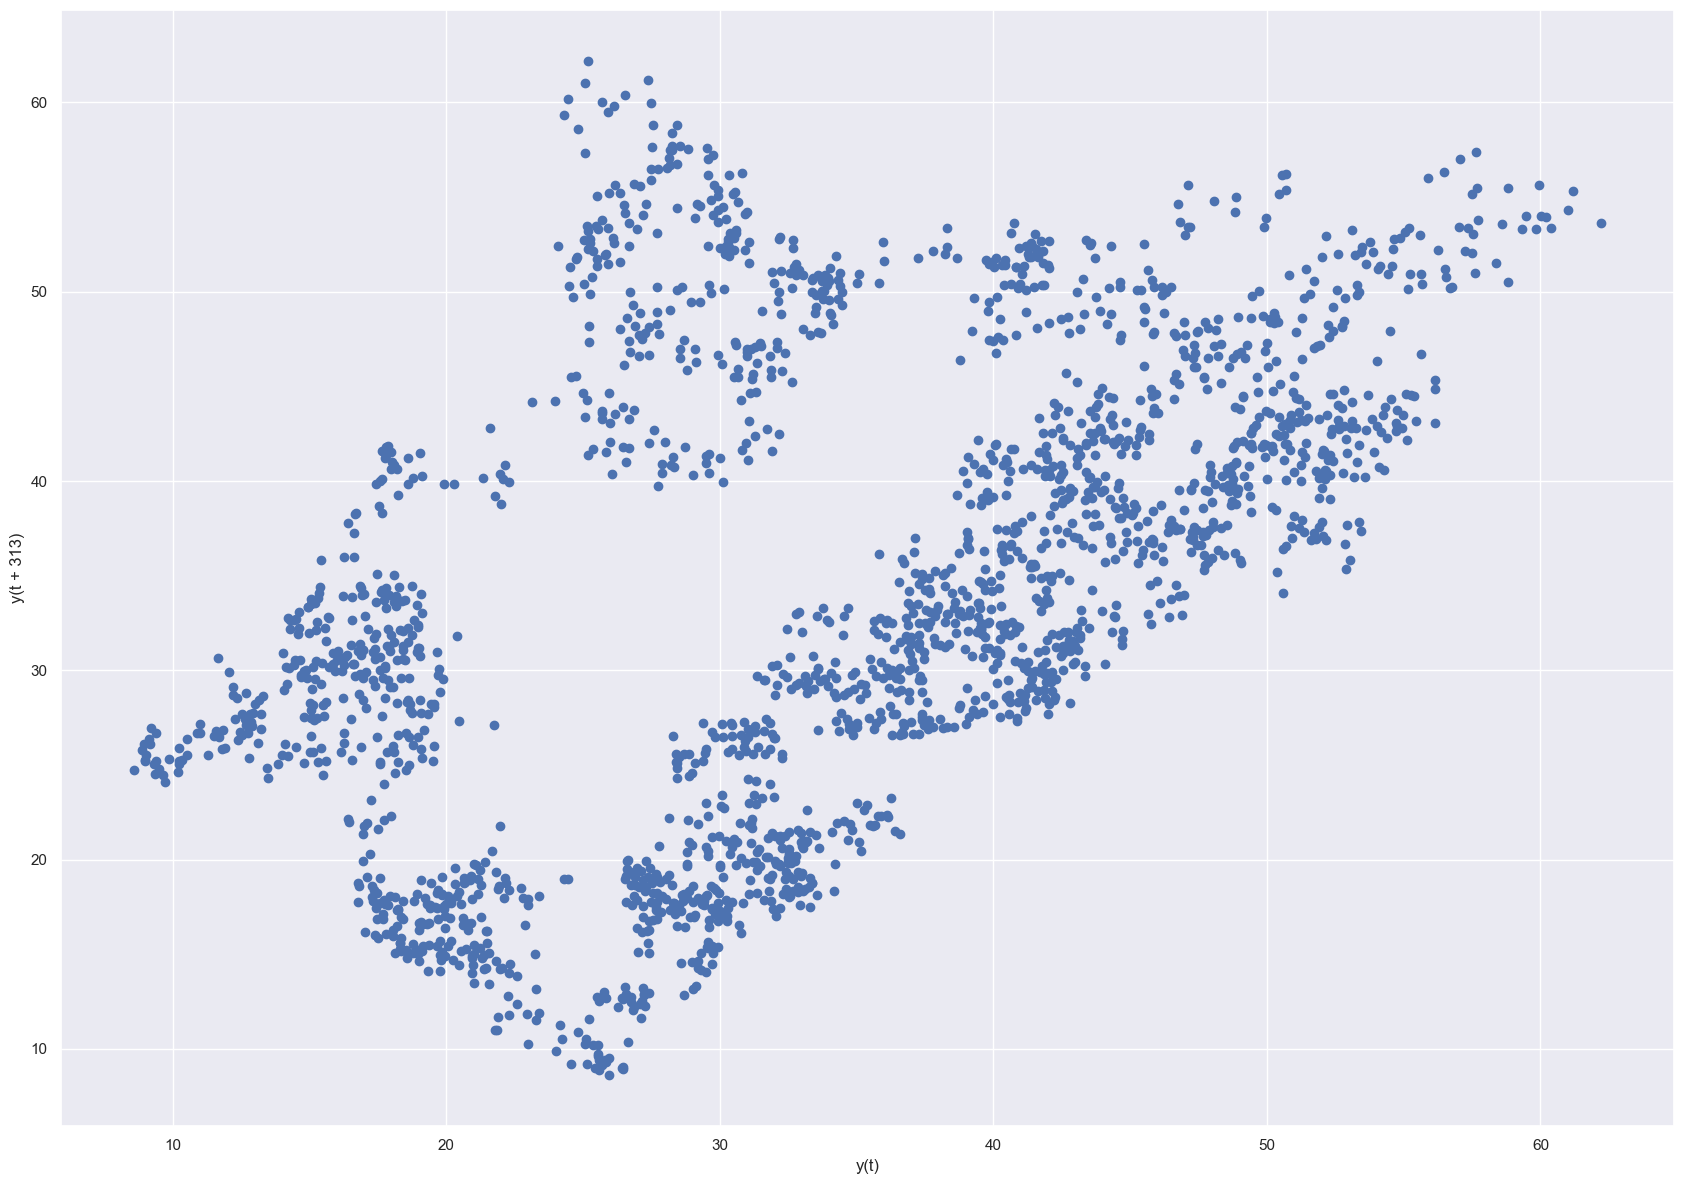

In [35]:
img_df_vale3_autocorr_313 = lag_plot(df_vale3_date_index['price'], lag=313)
save_image(img=img_df_vale3_autocorr_313, name='img_df_vale3_autocorr_313')

In [36]:
df_vale3_date_index['price'].autocorr(lag=314)

0.49925706901064987

There is still a correlation present up to 314 days.

#### Show lag variable

In [37]:
df_vale3_original_lag_30 = pd.concat([df_vale3_date_index['price'],
                                     df_vale3_date_index['price'].shift(30)], axis=1)

In [38]:
df_vale3_original_lag_30.head(50)

,price,price
date,,
2010-05-20,39.79,NaN
2010-05-21,42.46,NaN
2010-05-24,42.02,NaN
2010-05-25,42.39,NaN
2010-05-26,42.17,NaN
2010-05-27,44.82,NaN
2010-05-28,44.42,NaN
2010-05-31,45.37,NaN
2010-06-01,44.39,NaN


We can observe a large cluster of data points along a diagonal line, indicating a clear relationship or correlation.

img_df_vale3_autocorr_time saved at reports/images/.


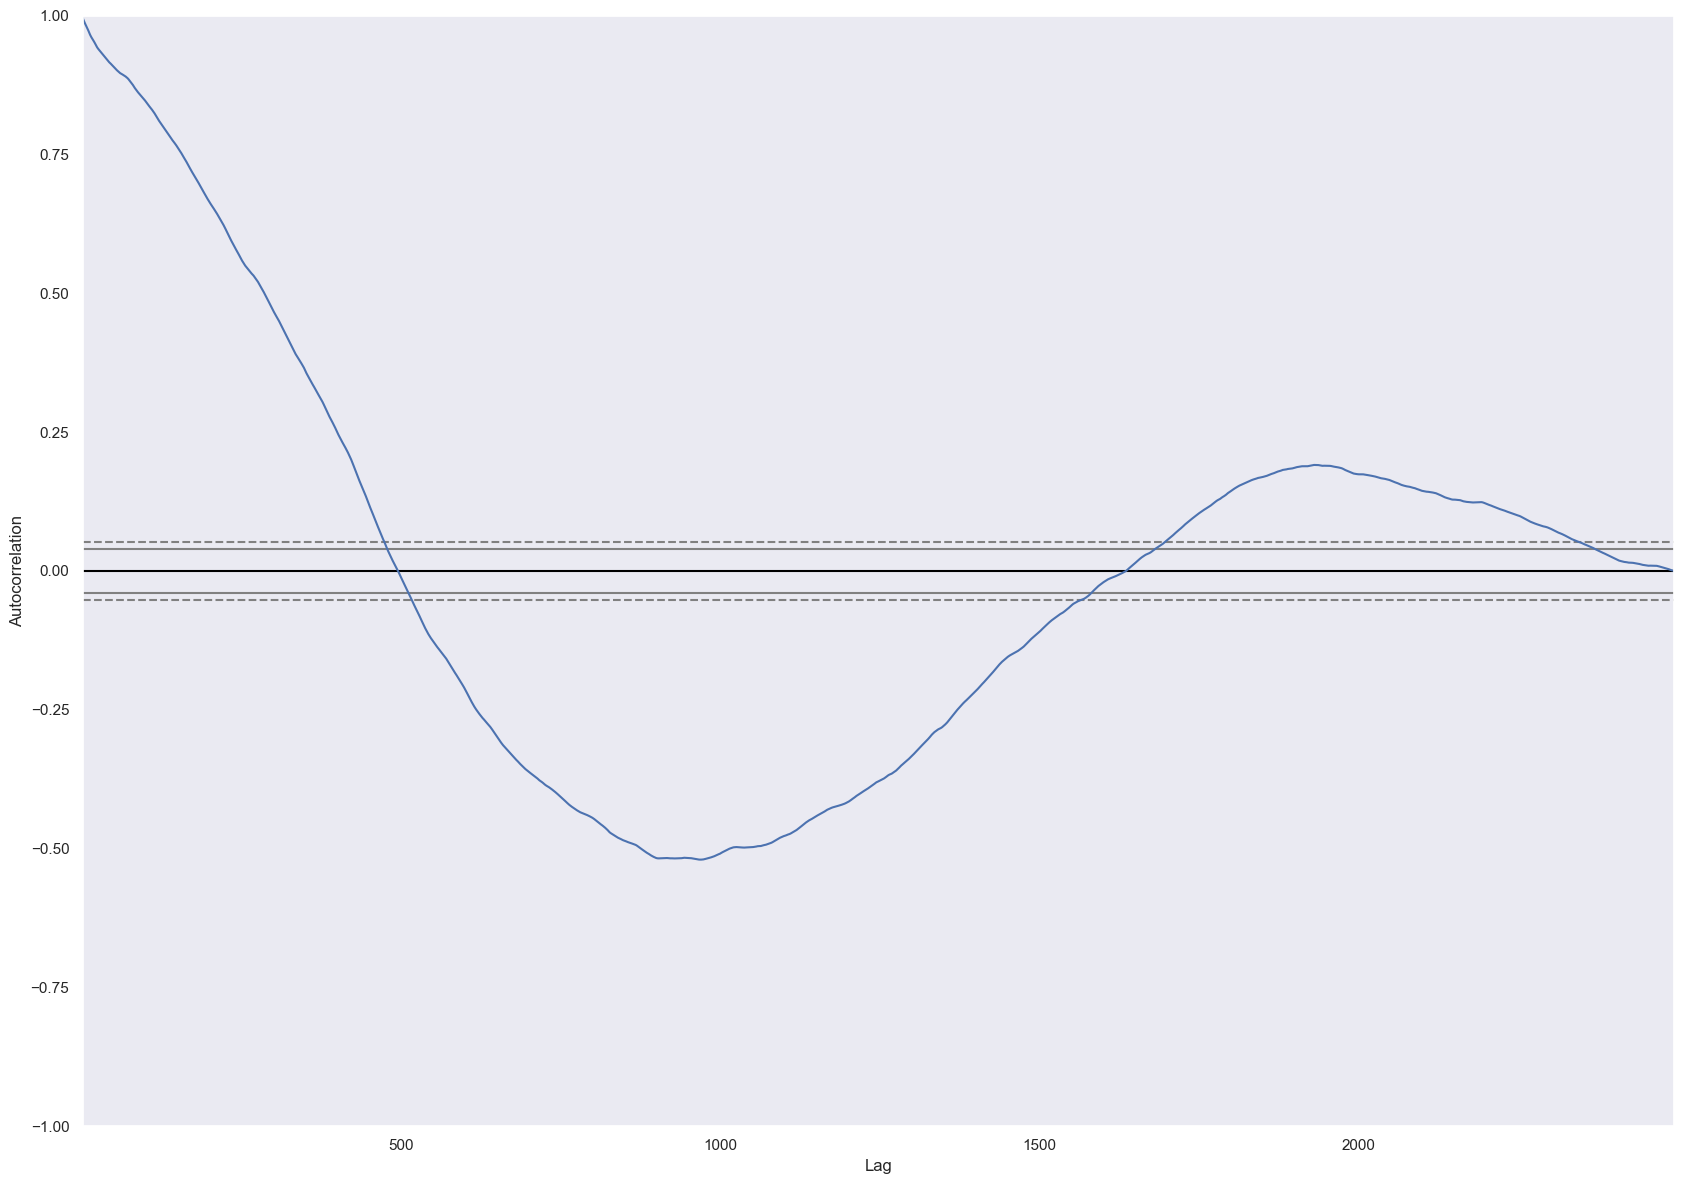

In [39]:
img_df_vale3_autocorr_time = autocorrelation_plot(df_vale3_date_index['price'])
save_image(img=img_df_vale3_autocorr_time, name='img_df_vale3_autocorr_time')

The confidence intervals are set at 95% and 99%, suggesting that correlation values outside of these intervals are highly likely to be genuine correlations rather than statistical coincidences.

### **Stationarity**
It's crucial to ensure that the data is stationary. This means that the time series exhibits a consistent behavior over time and is highly likely to continue this behavior in the future. Visually, the series isn't stationary. To confirm the behavior of this series, I will plot rolling statistics (mean, variance) and conduct the Dickey-Fuller test.

So, in this test, I evaluate two hypotheses:
- Null hypothesis (H0): it is non-stationary. It has some time-dependent structure.
- Alternative hypothesis (H1): it is stationary. It does not have a time-dependent structure.

In [40]:
type(df_vale3['price'])

pandas.core.series.Series

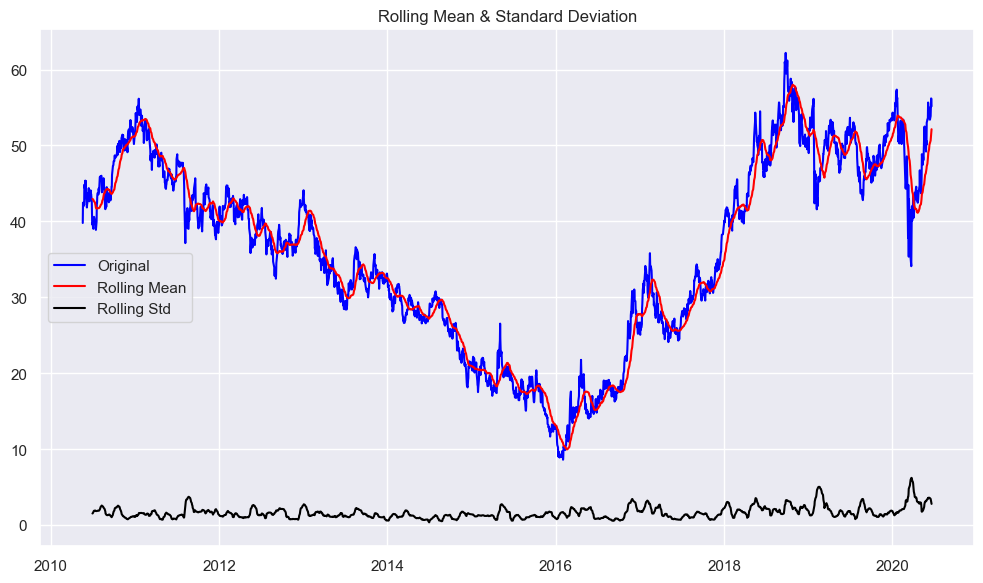

Results of Dickey-Fuller Test:
Test Statistic                  -0.93
p-value                          0.78
Lags Used                       27.00
Number of Observations Used   2467.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [41]:
test_stationary(df_vale3['price'])

**NOTES**
<br/>
- We used `autolag='AIC'` to let the function determine the lag, selecting the lowest observed value.
- **Test Statistic > Critical Value (1%)**: hence, H0 is accepted, indicating non-stationarity in the explored time series.
- In this case, it's necessary to make the time series stationary!

### Stationarity through Decomposition

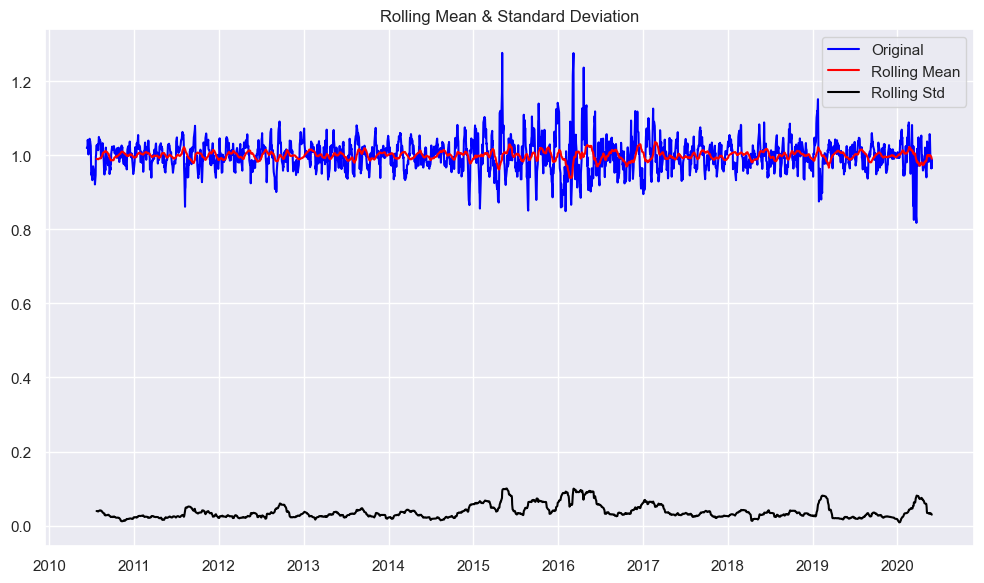

Results of Dickey-Fuller Test:
Test Statistic                 -12.43
p-value                          0.00
Lags Used                       27.00
Number of Observations Used   2437.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [42]:
residual
residual.dropna(inplace=True)
test_stationary(residual)

---

## **Data Preparation: Feature Engineering**

In [43]:
cols = ['data', 'preco', 'residuos', 'tendencia', 'sazonalidade']
df = pd.DataFrame(columns=cols)
df.head()

,data,preco,residuos,tendencia,sazonalidade


In [44]:
df['data'] = df_vale3['date']
df.head()

,data,preco,residuos,tendencia,sazonalidade
date,,,,,
2010-05-20,2010-05-20,NaN,NaN,NaN,NaN
2010-05-21,2010-05-21,NaN,NaN,NaN,NaN
2010-05-24,2010-05-24,NaN,NaN,NaN,NaN
2010-05-25,2010-05-25,NaN,NaN,NaN,NaN
2010-05-26,2010-05-26,NaN,NaN,NaN,NaN


In [45]:
df['preco'] = df_vale3['price']
df.head()

,data,preco,residuos,tendencia,sazonalidade
date,,,,,
2010-05-20,2010-05-20,39.79,NaN,NaN,NaN
2010-05-21,2010-05-21,42.46,NaN,NaN,NaN
2010-05-24,2010-05-24,42.02,NaN,NaN,NaN
2010-05-25,2010-05-25,42.39,NaN,NaN,NaN
2010-05-26,2010-05-26,42.17,NaN,NaN,NaN


In [46]:
df['tendencia'] = trend.values
df.head(20)

,data,preco,residuos,tendencia,sazonalidade
date,,,,,
2010-05-20,2010-05-20,39.79,NaN,NaN,NaN
2010-05-21,2010-05-21,42.46,NaN,NaN,NaN
2010-05-24,2010-05-24,42.02,NaN,NaN,NaN
2010-05-25,2010-05-25,42.39,NaN,NaN,NaN
2010-05-26,2010-05-26,42.17,NaN,NaN,NaN
2010-05-27,2010-05-27,44.82,NaN,NaN,NaN
2010-05-28,2010-05-28,44.42,NaN,NaN,NaN
2010-05-31,2010-05-31,45.37,NaN,NaN,NaN
2010-06-01,2010-06-01,44.39,NaN,NaN,NaN


In [47]:
df['sazonalidade'] = seasonal.values
df.head(20)

,data,preco,residuos,tendencia,sazonalidade
date,,,,,
2010-05-20,2010-05-20,39.79,NaN,NaN,1.00
2010-05-21,2010-05-21,42.46,NaN,NaN,1.00
2010-05-24,2010-05-24,42.02,NaN,NaN,1.00
2010-05-25,2010-05-25,42.39,NaN,NaN,1.00
2010-05-26,2010-05-26,42.17,NaN,NaN,1.00
2010-05-27,2010-05-27,44.82,NaN,NaN,1.00
2010-05-28,2010-05-28,44.42,NaN,NaN,1.00
2010-05-31,2010-05-31,45.37,NaN,NaN,1.00
2010-06-01,2010-06-01,44.39,NaN,NaN,1.00


In [50]:
residuos = residual.values

df = df[30:]
df['residuos'] = residuos
df.head()

,data,preco,residuos,tendencia,sazonalidade
date,,,,,
2010-07-02,2010-07-02,39.58,1.02,41.75,1.00
2010-07-05,2010-07-05,39.02,1.03,41.74,1.00
2010-07-06,2010-07-06,39.51,1.04,41.74,1.00
2010-07-07,2010-07-07,40.46,1.03,41.74,1.00
2010-07-08,2010-07-08,40.60,1.01,41.76,1.00


#### Generate Diferrence

In [51]:
df['diff_1'] = df['preco'].diff(periods=1)
df['diff_2'] = df['preco'].diff(periods=2)
df['diff_3'] = df['preco'].diff(periods=3)
df['diff_4'] = df['preco'].diff(periods=4)
df['diff_5'] = df['preco'].diff(periods=5)

df.dropna(inplace=True)
df.head(10)

---

## **Save Clean Data**

In [54]:
save_dataframe(df=df, path='data/cleansing/df_vale3_cleansing.csv')

saved data!


---
